In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

import string
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

import mediapipe as mp
from random import randint


import math
imgSize = 500

objc[18497]: Class CaptureDelegate is implemented in both /Users/parthokr/miniforge3/envs/asl-recognition/lib/python3.10/site-packages/cv2/cv2.abi3.so (0x156ece480) and /Users/parthokr/miniforge3/envs/asl-recognition/lib/python3.10/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x164380860). One of the two will be used. Which one is undefined.
objc[18497]: Class CVWindow is implemented in both /Users/parthokr/miniforge3/envs/asl-recognition/lib/python3.10/site-packages/cv2/cv2.abi3.so (0x156ece4d0) and /Users/parthokr/miniforge3/envs/asl-recognition/lib/python3.10/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x160764a68). One of the two will be used. Which one is undefined.
objc[18497]: Class CVView is implemented in both /Users/parthokr/miniforge3/envs/asl-recognition/lib/python3.10/site-packages/cv2/cv2.abi3.so (0x156ece4f8) and /Users/parthokr/miniforge3/envs/asl-recognition/lib/python3.10/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.d

## Define mediapipe

In [2]:
mp_draw = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

## Draw landmarks

In [3]:
def draw(img):
    img.flags.writeable = True
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    with mp_hands.Hands(min_detection_confidence=0.8, static_image_mode=True) as hands:
        results = hands.process(img)
        if results.multi_hand_landmarks:
            for handLandmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(img, handLandmarks, mp_hands.HAND_CONNECTIONS)
    cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img.flags.writeable = False

# Function to show image

In [5]:
def plot_sample(X, y, y_classes, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(f'Pred - {classes[y_classes[index]]} Test - {classes[int(y[index])]}')

# Read image

In [6]:
data_dir = 'asl_dataset/'
classes = string.ascii_lowercase[:5] + string.digits
X_train = []
y_train = np.array([])

for label in classes:
    y_train = np.append(y_train, [classes.index(label)]*len(os.listdir(f'{data_dir}/{label}')))

# print(y_train.shape)
for label in classes:
    for img in os.listdir(f'{data_dir}/{label}'):
        img = cv2.imread(f'{data_dir}/{label}/{img}')
        # X_train = np.append(X_train, [img])
#         draw(img)
        X_train.append(img)

# Resize images

In [7]:
i = 0
for img in X_train:
    imgWhite = np.ones((imgSize, imgSize, 3), np.uint8) * 255
    # print(croppedImg.shape)
    h, w, _ = img.shape
    if h > w:
        wCal = math.ceil(imgSize * w/h)
        resizedImage = cv2.resize(img, (wCal, imgSize))
        pushWidth = math.ceil((imgSize - wCal) / 2)
        imgWhite[:, pushWidth:pushWidth + wCal] = resizedImage
    else:
        hCal = math.ceil(imgSize * h/w)
        resizedImage = cv2.resize(img, (imgSize, hCal))
        pushHeight = math.ceil((imgSize - hCal) / 2)
        imgWhite[pushHeight:pushHeight + hCal, :] = resizedImage
    X_train[i] = imgWhite
    i += 1

## Normalize

In [13]:
X_train = [el / 255 for el in X_train]

## Run this cell for no test

In [3]:
X_train = np.array(X_train)

## Split dataset into test and train

In [8]:
# convert builtin array to numpy array
X_train = np.array(X_train)
# use 2% of data for test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.02)

In [14]:
X_train.shape

(1029, 500, 500, 3)

# Show some X_train

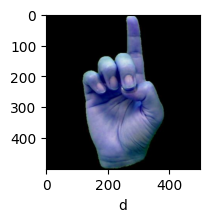

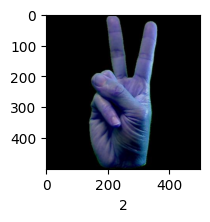

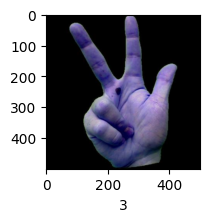

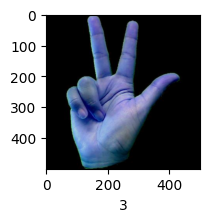

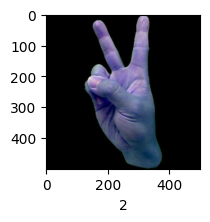

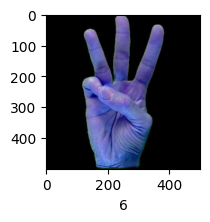

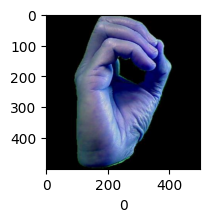

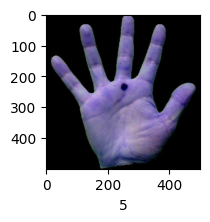

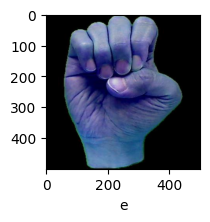

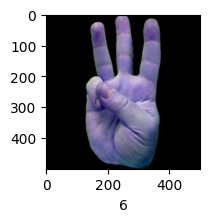

In [9]:
for _ in range(10):
    i = randint(0, len(X_train))
    plt.figure(figsize = (15,2))
    plt.imshow(X_train[i])
    plt.xlabel(classes[int(y_train[i])])

# Prepare CNN layers

In [10]:
cnn = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(imgSize, imgSize, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])
cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

2023-05-05 01:02:34.404583: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-05 01:02:34.405215: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


In [13]:
X_train.shape

(1029, 500, 500, 3)

# Train dataset

In [11]:
cnn.fit(X_train, y_train, epochs=3)

Epoch 1/3


2023-05-05 01:02:40.146452: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-05 01:02:40.585265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 17s 388ms/step - loss: 700.7327 - accuracy: 0.4674
Epoch 2/3
33/33 [==============================] - 12s 362ms/step - loss: 0.1496 - accuracy: 0.9611
Epoch 3/3
33/33 [==============================] - 12s 375ms/step - loss: 0.0099 - accuracy: 0.9961


## Summarize model

In [12]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 64)     0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 968256)            0         
                                                                 
 dense (Dense)               (None, 64)                6

# Evaluate against test dataset

In [14]:
cnn.evaluate(X_test, y_test)

1/1 [==============================] - 0s 434ms/step - loss: 0.3402 - accuracy: 0.9048


[0.3402145802974701, 0.9047619104385376]

# Show results

1/1 [==============================] - 0s 28ms/step


/var/folders/pm/_1qfvv0n19z52z6tpxr_x4fr0000gn/T/ipykernel_3723/844425026.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (15,2))


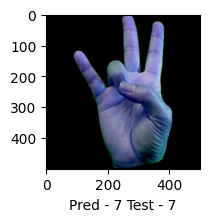

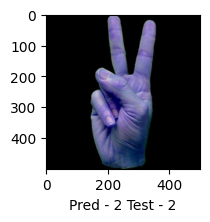

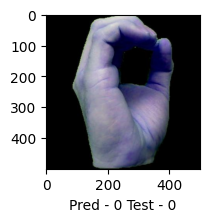

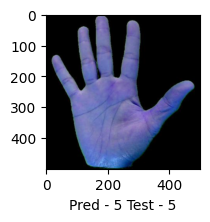

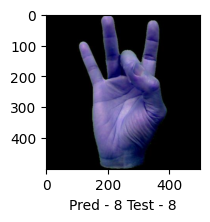

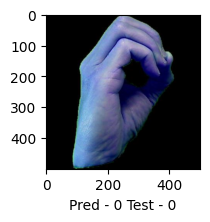

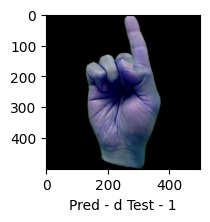

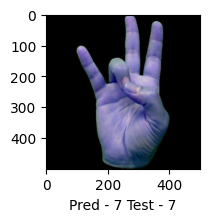

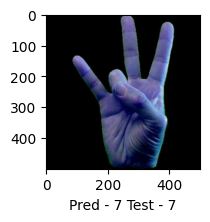

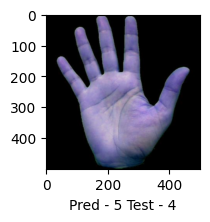

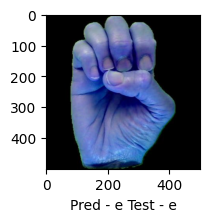

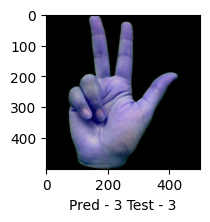

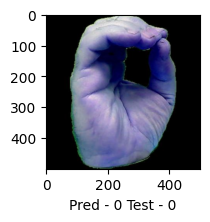

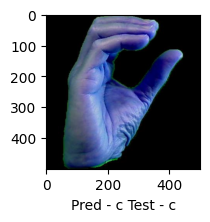

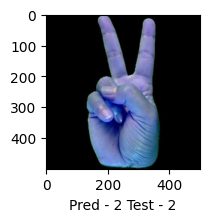

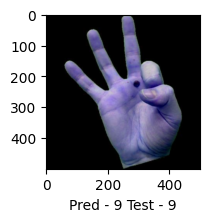

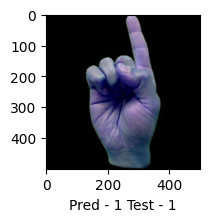

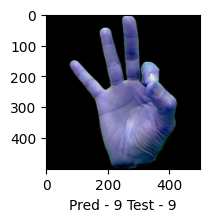

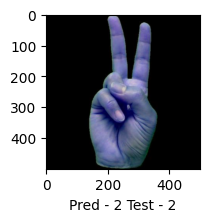

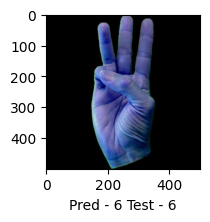

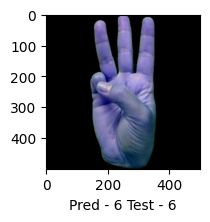

In [15]:
y_pred = cnn.predict(X_test)
y_classes = [np.argmax(el) for el in y_pred]
# print(y_classes)
for i in range(len(y_classes)):
    plot_sample(X_test, y_test, y_classes, i)

# Save model

In [6]:
cnn.save("cnn_model_final.h5")